## Learning bi-partite motifs based on a thermodynamic approach
### import libraries and functions

In [1]:
#imports
exec(compile(open('src/load_libs.py', 'rb').read(), 'src/load_libs.py', 'exec')) 

#dynamic programming implementation of the LL class
exec(compile(open('src/LL_avx.py', 'rb').read(), 'src/LL_avx.py', 'exec')) 

#the wrapper functions, gradient descent implementation
exec(compile(open('src/ADAM_func.py', 'rb').read(), 'src/ADAM_func.py', 'exec')) 

random.seed(42)

### Import data

### RBNS

In [2]:
#RBNS DATASET
if False:
    factor_number = 0

    #define paths for RBNS dataset files
    rbp_path = '../rbns_scratch/data'
    factors = np.sort(os.listdir(rbp_path)) #list available factors

    all_files = [os.listdir(os.path.join(rbp_path, factor)) for factor in factors]

    pulldown_files = [np.sort(files)[2] for files in all_files]  #take 320 concentration when available otherwise another concentration
    input_files = [[f for f in files if '_input_' in f][0] for files in all_files]
    concentrations = [f.split('_')[1] for f in pulldown_files] #see which concentration we took

    if factor_number in range(len(factors)):
        factor = factors[factor_number]
        concentration = concentrations[factor_number]
        print(f'processing {factor}')
        bg = os.path.join(rbp_path,factor,input_files[factor_number])
        pos = os.path.join(rbp_path,factor,pulldown_files[factor_number])

    background_set = parse_fastq(bg)
    background_set = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in background_set]
    print(f'dataset has {len(background_set)} background sequences.')

    positive_set = parse_fastq(pos)
    positive_set = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in positive_set]
    print(f'dataset has {len(positive_set)} positive sequences.')

### HT-SELEX

In [25]:
factor_number = 49
if True:
    
    #parse the dataset to find the corresponding files for each factor
    selex_files = np.loadtxt('selex_files.txt', dtype=str) #name of all files

    #first part of file_name is the protein name
    factors = np.unique([s.split('_')[0] for s in selex_files]) 

    #select the factor based on the input
    factor = factors[factor_number]

    #files that correspond to this factor
    factor_files = selex_files[np.array([factor in s for s in selex_files])]
    factor_barcodes = np.unique([s.split('_')[1] for s in factor_files])
    files_by_bc = []
    for bc in factor_barcodes:
        files = factor_files[np.array([bc in s for s in factor_files])]
        corresponding_bg_file = selex_files[np.array([(bc in s)&('ZeroCycle' in s) for s in selex_files])][0]
        files_with_bg = np.append(files,corresponding_bg_file)
        files_with_bg_sorted_by_cycle = files_with_bg[np.argsort([int(f.split('_')[3]) for f in files_with_bg])]
        files_by_bc.append(files_with_bg_sorted_by_cycle)

In [ ]:
selex_files = files_by_bc[0]
avg_auc = []

selex_files = [os.path.join('../rbp_scratch/data', f) for f in selex_files]

train_sets = []
test_sets = []

#separate trainig and test sets
for i in range(len(selex_files)):
    
    sequences = parse_fastq(selex_files[i])
    sequences = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in sequences]
    
    #calculate the size for x fraction of dataset
    fraction = 0.2
    no_seqs  = int(len(sequences)*fraction)
    
    #partition the test and training sets
    train, test = partition(sequences[:no_seqs], 2)
    
    train_sets.append(train)
    test_sets.append(test)
    
    
#parameter initialization
np.random.seed(0)

core_length = 3

Ea = np.random.normal(loc=12.0, scale=1.0, size=4**core_length)
Eb = np.random.normal(loc=12.0, scale=1.0, size=4**core_length)
sf = np.log(10000)
r = np.log(np.random.uniform(1,15))
p = 0

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])

var_thr = 0.03
seq_per_batch = 500

#calculate auc values for consecutive  pairs 
for bg_inx in range(0,len(selex_files)-1):

    print(bg_inx)
    maxiter=300
    
    file_name = f'dev_{bg_inx}_{maxiter}iterations_{core_length}cl'
    theta_0, g_t  = optimize_adam(
                                        train_sets[bg_inx+1], train_sets[bg_inx], 
                                        test_sets[bg_inx+1], test_sets[bg_inx], 
                                        core_length=core_length,
                                        var_thr=var_thr, 
                                        sequences_per_batch=seq_per_batch, 
                                        max_iterations=maxiter, 
                                        evaluate_after=4000,
                                        save_files=True
                                        )
    
    kmer_inx = generate_kmer_inx(core_length)
    auc_list = []
    
    #calculate the performance (AUC) of the obtained parameters on all consecutive selex rounds
    for bg_inx in range(0,len(selex_files)-1):
        _,_,auc = auc_evaluate(theta_0, test_sets[bg_inx+1], test_sets[bg_inx], core_length, kmer_inx)
        auc_list.append(auc)

    #calculate average auc obtained with theta_0
    avg_auc.append(np.mean(auc_list))

0


In [23]:
np.argmax(avg_auc)

2

In [24]:
avg_auc

[0.6068883996761594,
 0.6071798883047074,
 0.6076108840845349,
 0.6058355399559245]

In [16]:
avg_auc # 300iterations 3 cores

[0.608522534592342, 0.6246134208656413, 0.6308051850469123, 0.5387608959198515]

In [14]:
avg_auc #300iterations

[0.6364822112598901,
 0.6431817224879031,
 0.6430316439607133,
 0.5687639534075045]

In [12]:
avg_auc #1000iterations

[0.6426737839334213, 0.6401052715095901, 0.6289252162657615, 0.556990202375104]

In [10]:
avg_auc #100iterations

[0.5980110001097338, 0.6205769295602022, 0.64062299582889, 0.5640745145593189]

### Simulated data

In [3]:
random.seed(42)

background_set = parse_fasta('negatives_toy.fasta')
positive_set = parse_fasta('positives_toy.fasta')

In [4]:
bg_train, bg_valid = partition(background_set, 2)
pos_train, pos_valid = partition(positive_set, 2)

## Run parameter optimization 

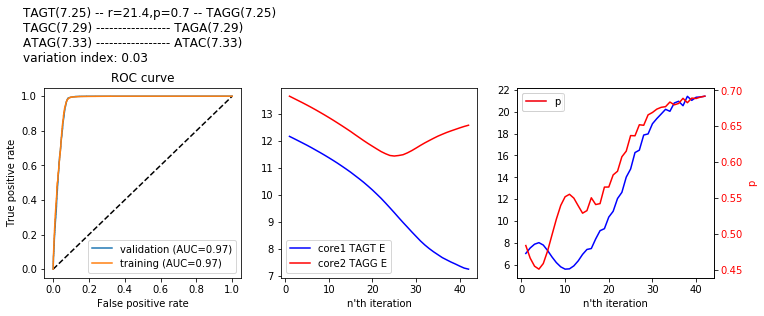

In [22]:
for i in range(0,1):
    np.random.seed(i)

    core_length = 4
    
    Ea = np.random.normal(loc=12.0, scale=1.0, size=4**core_length)
    Eb = np.random.normal(loc=12.0, scale=1.0, size=4**core_length)
    sf = np.log(10000)
    r = np.log(np.random.uniform(1,15))
    p = 0

    parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])
    
    var_thr = 0.03
    
    seq_per_batch = 500
    
    file_name = f'toy_{i}'

    maxiter=1000
    if True:
        theta_0, g_t  = optimize_adam(
                                        pos_train, bg_train, 
                                        pos_valid, bg_valid, 
                                        core_length=core_length,
                                        var_thr=var_thr, 
                                        sequences_per_batch=seq_per_batch, 
                                        max_iterations=maxiter, 
                                        evaluate_after=4000
                                        )
    

In [14]:
#imports
exec(compile(open('src/load_libs.py', 'rb').read(), 'src/load_libs.py', 'exec')) 

#dynamic programming implementation of the LL class
exec(compile(open('src/LL_avx.py', 'rb').read(), 'src/LL_avx.py', 'exec')) 

#the wrapper functions, gradient descent implementation
exec(compile(open('src/ADAM_func.py', 'rb').read(), 'src/ADAM_func.py', 'exec')) 

random.seed(42)

In [2]:
Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
sf = np.log(100)
r = 0.5
p = 0.5

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])

In [3]:
param = parameters
intrep = seq2int_cy('AAGAAGGCATAGTTTGCGATTTAGCGGCTGACATTAAATC')

for comp in [0,127,128,129,130]:
    epsilon = 1e-5
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = DP_Z_cy(x_fwd, intrep)[0]
    fx_rev = DP_Z_cy(x_rev, intrep)[0]
    
    print('component %d'%comp)
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(DP_Z_cy(param, intrep)[1][comp])

component 0
-4.692468635880687e-06
-4.69247594151443e-06
component 127
-1.245470393484993e-05
-1.245474638876641e-05
component 128
4.2188474935755943e-10
4.2023572600514797e-10
component 129
3.2418512319054567e-09
3.2835059284631946e-09
component 130
-4.818367926873179e-09
-4.854353684663969e-09


In [15]:
n = 100
nll_obj = nLL(positive_set[:n], background_set[:n])


Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
sf = np.log(100)
r = np.log(0.5)
p = np.log(0.5)

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])
param = parameters

for comp in [0, 127,128,129,130]:
    epsilon = 1e-5
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = nll_obj(x_fwd)[0]
    fx_rev = nll_obj(x_rev)[0]
    
    print('component %d\t, 1=%f, 2=%f'%(comp, fx_fwd, nll_obj(param)[0]))
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(nll_obj(param)[1][comp])

component 0	, 1=533.487452, 2=533.487451
0.03890284574481484
0.03890294468698802
component 127	, 1=533.487452, 2=533.487451
0.07215142545646813
0.07215155496568709
component 128	, 1=533.487451, 2=533.487451
0.0007133394319680518
0.0007129654955893132
component 129	, 1=533.487451, 2=533.487451
0.0003231377831980353
0.0003231206133736224
component 130	, 1=533.487451, 2=533.487451
1.5216983229038304e-05
1.563850826062949e-05
